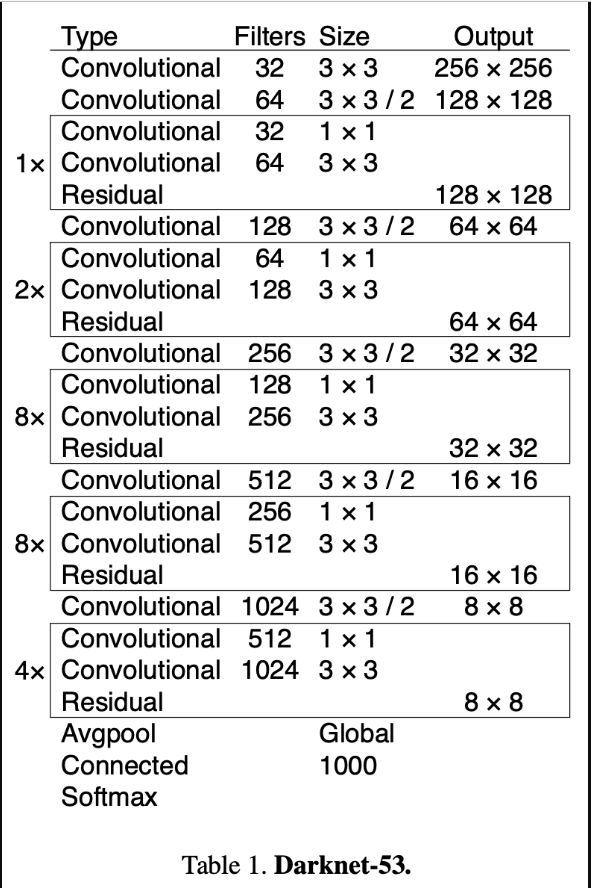

In [1]:
import torch
import torch.nn as nn


def Conv(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.Mish(inplace=True))

In [2]:
class Residual(nn.Module):
    def __init__(self, in_channels):
        super(Residual, self).__init__()
        reduced_dim = in_channels // 2
        self.layer1 = Conv(in_channels=in_channels, out_channels=reduced_dim, kernel_size=1, padding=0)
        self.layer2 = Conv(in_channels=reduced_dim, out_channels=in_channels, kernel_size=3, padding=1)
        
        
    def forward(self, x):
        x += self.layer2(self.layer1(x))
        return x

In [3]:
class Darknet(nn.Module):
    def __init__(self, in_channels, n_repeats=[1, 2, 8, 8, 4], num_classes=1000):
        super(Darknet, self).__init__()
        self.in_channels = 64
        self.extractor = nn.Sequential(
            Conv(in_channels, out_channels=32, kernel_size=3),
            Conv(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        )
        self.layer1 = self._make_layers(num_rep=n_repeats[0])
        self.layer2 = self._make_layers(num_rep=n_repeats[1])
        self.layer3 = self._make_layers(num_rep=n_repeats[2])
        self.layer4 = self._make_layers(num_rep=n_repeats[3])
        self.layer5 = self._make_layers(num_rep=n_repeats[4], transition=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)        
        
    
    def forward(self, x):
        x = self.extractor(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
        
        
    def _make_layers(self, num_rep, transition=True):
        layers = []
        
        for i in range(num_rep):
            layers.append(
                Residual(self.in_channels)
            )
        
        if transition:
            layers.append(
                Conv(self.in_channels, out_channels=self.in_channels*2, kernel_size=3, padding=1, stride=2)
            )
            self.in_channels *= 2
        return nn.Sequential(*layers)

In [4]:
Darknet53 = Darknet(in_channels=3)

In [5]:
Darknet53(torch.randn((32, 3, 224, 224))).shape

torch.Size([32, 1000])